# Data Cleaning - Running Metadata of the RICKD Analysis

In this notebook we will focus on cleaning the run_data_meta.csv file with what we have learned from the previous notebook.

- Coalesce `SpecInjury` and `SpecInjury2` into a single column as the main injury.
- Consolidating categorical data (i.e. Other/Other, Plantar fasciitis/Plantar fasciitis)
- Removing duplicates if they exist.
- Clean free text fields.
- Consolidate data from multiple sessions for the same subject.
- Some subjects have been registered under the same ID but they are different people. i.e. 200375
- Investigate outliers in the data.
- Investigate missing data.

# Output datasets:
- run_data_meta_cleaned.csv

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from core.constants import RICKD_RUNNING_METADATA_FILE, RICKD_RESULTS_FOLDER, RICKD_PROCESSED_DATA_FOLDER
from core.data_quality import standardize_free_text_col

In [2]:
run_data_meta = pd.read_csv(RICKD_RUNNING_METADATA_FILE)

In [3]:
from core.data_quality import to_lowercase
# All values in lower case helps with consolidating categories without information loss.
run_data_meta_cleaned = run_data_meta.copy()
run_data_meta_cleaned = to_lowercase(run_data_meta_cleaned)


run_data_meta_cleaned = standardize_free_text_col(run_data_meta_cleaned, ['Activities'])

# We want all missing/invalid values to be represented as None for consistency.
# There is a difference between a missing value and a valule like "other" or "no injury".
invalid_values = [
    "nan",
    "hh",
    "mm",
    "ss",
    "",
]
run_data_meta_cleaned = run_data_meta_cleaned.replace(invalid_values, None)
run_data_meta_cleaned.head()

,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,SpecInjury2,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces
0,100433,2010-10-05 13:22:40,20101005t132240.json,1.610861,53,NaN,NaN,unknown,NaN,training volume/intensity affected,...,NaN,"walking, horseback riding, strength training",recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN
1,100434,2010-11-17 13:22:40,20101117t132240.json,2.237294,51,NaN,NaN,female,NaN,training volume/intensity affected,...,NaN,"running, swimming",recreational,20.0,casual runner (no times),NaN,NaN,NaN,NaN,NaN
2,100537,2012-07-03 10:25:50,20120703t102550.json,2.127441,255,173.1,67.6,female,right,2 workouts missed in a row,...,NaN,"hiking, power walking, pilates",recreational,2.0,casual runner (no times),NaN,NaN,NaN,NaN,NaN
3,100560,2012-07-17 10:37:48,20120717t103748.json,2.657365,33,179.3,83.0,female,right,no injury,...,NaN,yoga,recreational,NaN,casual runner (no times),NaN,NaN,NaN,NaN,NaN
4,101481,2012-07-17 10:50:21,20120717t105021.json,2.625088,32,176.3,58.6,female,NaN,no injury,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# If only secondary injury is populated, it becomes the primary.
# Also only populate SpecInjury2 if it is different from SpecInjury.
print("Before:")
display(run_data_meta_cleaned[(run_data_meta_cleaned['sub_id'] == 201091)][['SpecInjury', 'SpecInjury2']])

run_data_meta_cleaned['SpecInjury'] = run_data_meta_cleaned['SpecInjury'].combine_first(run_data_meta_cleaned['SpecInjury2'])
run_data_meta_cleaned['SpecInjury2'] = run_data_meta_cleaned.apply(
    lambda row: None if row['SpecInjury2'] == row['SpecInjury'] else row['SpecInjury2'],
    axis=1
)
print("\nAfter:")
run_data_meta_cleaned[(run_data_meta_cleaned['sub_id'] == 201091)][['SpecInjury', 'SpecInjury2']]

Before:


,SpecInjury,SpecInjury2
1793,NaN,calf muscle strain



After:


,SpecInjury,SpecInjury2
1793,calf muscle strain,None


In [5]:
# We have identified that some subjects have been registered under the same ID but they are different people.
# We must separate them and give them a new ID.
# 200375 has 4 sessions with different gender and the age change between sessions does not match datestring.
run_data_meta_cleaned['sub_id_orig'] = run_data_meta_cleaned['sub_id']
subject_200375 = run_data_meta_cleaned[run_data_meta_cleaned['sub_id'] == 200375]

# Create a new subject ID for the female entries
new_subject_id = 200375 + 100000
run_data_meta_cleaned.loc[(run_data_meta_cleaned['sub_id'] == 200375) &
                         (run_data_meta_cleaned['Gender'] == 'female'), 'sub_id'] = new_subject_id

# Display the results to verify the split
print("Before:")
display(subject_200375[['sub_id', 'Gender', 'datestring', 'age']])
print("\nAfter:")
display(run_data_meta_cleaned[run_data_meta_cleaned['sub_id'].isin([200375, new_subject_id])][['sub_id', 'Gender', 'datestring', 'age']].sort_values(by='sub_id'))


Before:


,sub_id,Gender,datestring,age
1491,200375,male,2014-05-01 14:27:37,51
1492,200375,female,2014-05-02 07:30:48,27
1493,200375,female,2014-05-02 07:41:59,27
1494,200375,male,2014-05-09 07:06:51,51



After:


,sub_id,Gender,datestring,age
1491,200375,male,2014-05-01 14:27:37,51
1494,200375,male,2014-05-09 07:06:51,51
1492,300375,female,2014-05-02 07:30:48,27
1493,300375,female,2014-05-02 07:41:59,27


In [6]:
# We have identified that the age of 100234 does not match the time between sessions.
# She is 3 years older in less than 1 year between sessions.
# We will assume that the first session is the correct one and we will override the age to 41 on the second session.
subject_100234 = run_data_meta_cleaned[run_data_meta_cleaned['sub_id'] == 100234]
run_data_meta_cleaned.loc[(run_data_meta_cleaned['sub_id'] == 100234) &
                         (run_data_meta_cleaned['datestring'] == '2012-05-18 09:44:09'), 'age'] = 41
run_data_meta_cleaned[run_data_meta_cleaned['sub_id'] == 100234]

,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,InjDefn,...,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces,sub_id_orig
1150,100234,2011-10-06 13:21:51,20090909t201123.json,2.504259,40,165.3,56.4,female,left,no injury,...,running,competitive,4.5,casual runner (no times),NaN,NaN,NaN,NaN,NaN,100234
1355,100234,2012-05-18 09:44:09,20120518t094409.json,2.278154,41,165.0,57.3,female,right,no injury,...,"running, walking, bike, swim",recreational,NaN,casual runner (no times),NaN,NaN,NaN,NaN,NaN,100234


In [7]:
# Create a surrogate key for each session
id_df = run_data_meta_cleaned['sub_id'].astype(str) + '_' + run_data_meta_cleaned['filename'].str.replace('.json', '')
run_data_meta_cleaned.insert(0, 'id', id_df)
run_data_meta_cleaned[['id', 'sub_id', 'filename']].head(1)


,id,sub_id,filename
0,100433_20101005t132240,100433,20101005t132240.json


In [8]:
from core.constants import RICKD_RUNNING_METADATA_CLEANED_FILE

run_data_meta_cleaned.to_csv(RICKD_RUNNING_METADATA_CLEANED_FILE, index=False)

In [9]:
run_data_meta_cleaned.head()

,id,sub_id,datestring,filename,speed_r,age,Height,Weight,Gender,DominantLeg,...,Activities,Level,YrsRunning,RaceDistance,RaceTimeHrs,RaceTimeMins,RaceTimeSecs,YrPR,NumRaces,sub_id_orig
0,100433_20101005t132240,100433,2010-10-05 13:22:40,20101005t132240.json,1.610861,53,NaN,NaN,unknown,NaN,...,"walking, horseback riding, strength training",recreational,13.0,10k,NaN,NaN,NaN,NaN,NaN,100433
1,100434_20101117t132240,100434,2010-11-17 13:22:40,20101117t132240.json,2.237294,51,NaN,NaN,female,NaN,...,"running, swimming",recreational,20.0,casual runner (no times),NaN,NaN,NaN,NaN,NaN,100434
2,100537_20120703t102550,100537,2012-07-03 10:25:50,20120703t102550.json,2.127441,255,173.1,67.6,female,right,...,"hiking, power walking, pilates",recreational,2.0,casual runner (no times),NaN,NaN,NaN,NaN,NaN,100537
3,100560_20120717t103748,100560,2012-07-17 10:37:48,20120717t103748.json,2.657365,33,179.3,83.0,female,right,...,yoga,recreational,NaN,casual runner (no times),NaN,NaN,NaN,NaN,NaN,100560
4,101481_20120717t105021,101481,2012-07-17 10:50:21,20120717t105021.json,2.625088,32,176.3,58.6,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101481


In [10]:
# Add new columns:
import os
run_data_meta_cleaned['session_file_path'] = run_data_meta_cleaned.apply(lambda row: os.path.join(str(row['sub_id_orig']), row['filename']), axis=1)

In [11]:
print("% of missing values per column after cleaning:")
run_data_meta_cleaned.isnull().sum() / len(run_data_meta_cleaned) * 100

% of missing values per column after cleaning:


id                    0.000000
sub_id                0.000000
datestring            0.000000
filename              0.000000
speed_r               0.000000
age                   0.000000
Height                0.163755
Weight                0.109170
Gender                0.000000
DominantLeg          19.213974
InjDefn               4.366812
InjJoint             12.772926
InjSide              26.528384
SpecInjury           32.096070
InjDuration          77.893013
InjJoint2            54.366812
InjSide2             55.131004
SpecInjury2          85.316594
Activities           17.248908
Level                14.683406
YrsRunning           28.220524
RaceDistance         18.449782
RaceTimeHrs          69.705240
RaceTimeMins         61.735808
RaceTimeSecs         75.709607
YrPR                 76.801310
NumRaces             72.489083
sub_id_orig           0.000000
session_file_path     0.000000
dtype: float64

In [12]:
run_data_meta_cleaned.to_csv(RICKD_RUNNING_METADATA_CLEANED_FILE, index=False)


In [22]:
# Combine SpecInjury and SpecInjury2 columns and get unique values
combined_injuries = pd.concat([run_data_meta_cleaned['SpecInjury'], run_data_meta_cleaned['SpecInjury2']]).dropna().drop_duplicates().reset_index(drop=True)

print("### Distinct Injury Types")
print("```")
for injury in sorted(combined_injuries):
    print(f"- {injury}")
print("```")

print("\n### Distinct Injury Definitions")
print("```")
for injury_def in sorted(run_data_meta_cleaned['InjDefn'].dropna().unique()):
    print(f"- {injury_def}")
print("```")


### Distinct Injury Types
```
- achilles tendonitis
- bursitis
- calf muscle strain
- chondromalacia
- compartment syndrome
- cyst
- deformity (e.g hammer/claw toes, bunion)
- deformity(ie hammer/claw toes, bunion)
- disc degeneration
- disc protrusion
- dislocation
- fibula fracture
- fibula stress fracture
- fill in specifics below
- first ray tendonitis (turf toe)
- gastrocnemius strain
- groin muscle strain
- hamstring muscle strain
- high ankle sprain with tendonosis
- hip flexor strain
- hip joint irritation
- ischial bursitis
- itb syndrome
- labral tear
- ligament sprain
- ligament tear/rupture acl
- ligament tear/rupture mcl
- ligament tear/rupture pcl
- ligament tear/rupture-acl
- low back pain
- medial tibial stress syndrome
- meniscal tear medial
- meniscal tear-lateral
- meniscal tear-medial
- metarsalgia
- metatarsal stress fracture
- muscle spasm
- muscle strain
- mva, not running related
- nerve impingement
- no injury
- non-specific injury
- osteitis pubis
- osteoarthr

In [33]:
injury_mapping = pd.DataFrame({'injury': combined_injuries}, columns=['injury', 'code'])
injury_mapping.to_csv(os.path.join(RICKD_PROCESSED_DATA_FOLDER, 'injury_mappings.csv'), index=False)


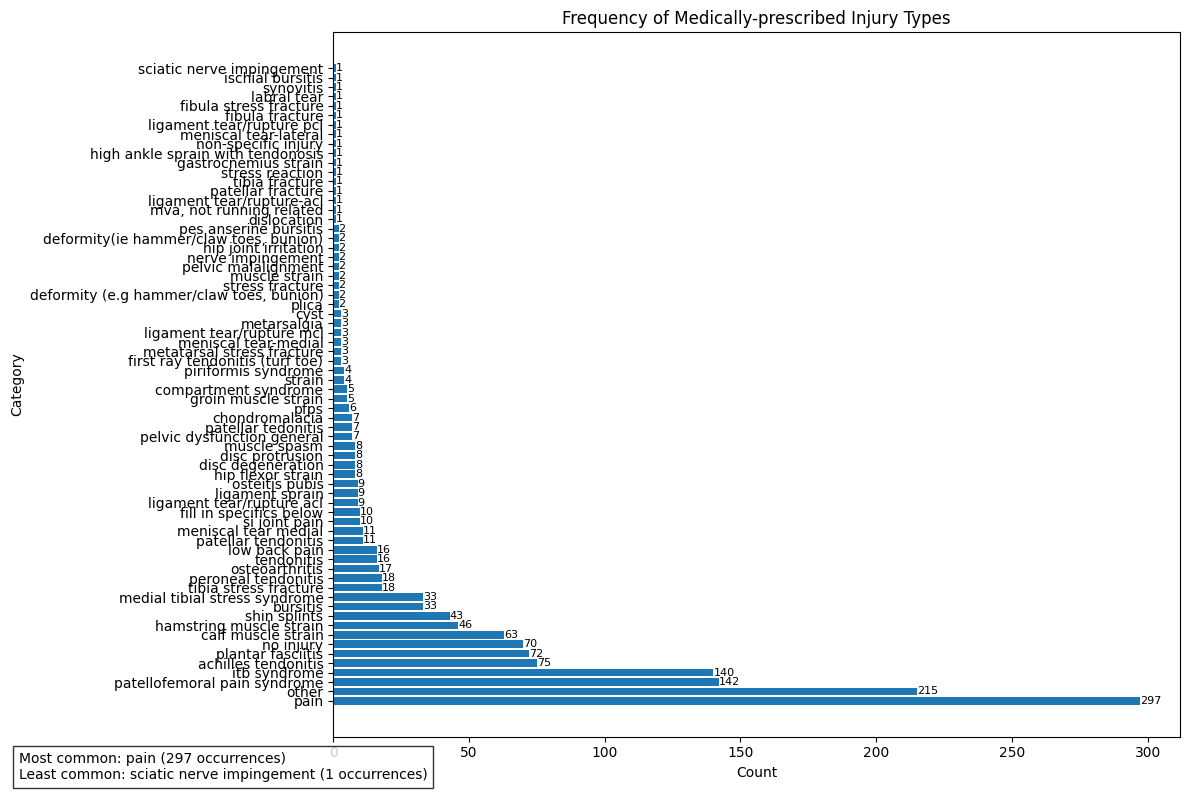

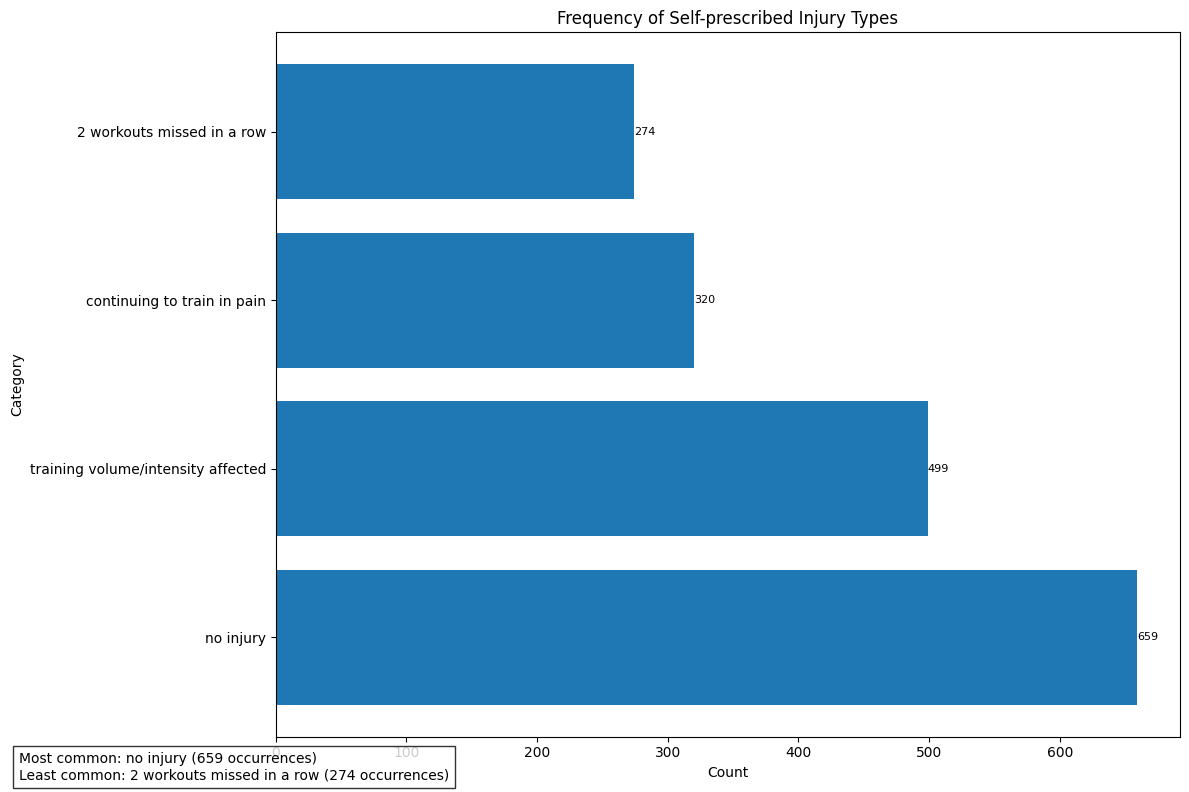

In [28]:
def plot_frequency_distribution(data, title, output_filename):
    """
    Create and save a horizontal bar plot showing frequency distribution.
    
    Args:
        data: pandas Series or DataFrame column containing the data to plot
        title: str, title for the plot
        output_filename: str, name of the file to save the plot
    """
    # Get frequencies
    value_counts = data.value_counts()
    
    # Create horizontal bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(value_counts.index, value_counts.values)
    
    # Add value labels on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                 ha='left', va='center', fontsize=8)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel('Category')
    
    # Show max and min values
    max_value = value_counts.index[0]
    min_value = value_counts.index[-1]
    plt.figtext(0.02, 0.02, 
                f'Most common: {max_value} ({value_counts.iloc[0]} occurrences)\n'
                f'Least common: {min_value} ({value_counts.iloc[-1]} occurrences)', 
                fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure to results folder
    plt.savefig(os.path.join(RICKD_RESULTS_FOLDER, output_filename), 
                bbox_inches='tight', dpi=300)
    plt.show()

# Plot injury types
injury_data = pd.concat([run_data_meta_cleaned['SpecInjury'], run_data_meta_cleaned['SpecInjury2']])
plot_frequency_distribution(
    injury_data,
    'Frequency of Medically-prescribed Injury Types',
    'medically_prescribed_injury_type_frequency.png'
)

# Plot injury definitions
plot_frequency_distribution(
    run_data_meta_cleaned['InjDefn'],
    'Frequency of Self-prescribed Injury Types',
    'self_prescribed_injury_definition_frequency.png'
)
